## Refine Neural cell annotations for large intestine - relabelling uncertain cells based on majority voting

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import sys
import os
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import ast

In [2]:
sc.logging.print_header()

scanpy==1.8.0 anndata==0.8.0 umap==0.4.6 numpy==1.20.1 scipy==1.6.1 pandas==1.3.5 scikit-learn==0.24.1 statsmodels==0.13.5 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.2


In [3]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [4]:
sc.set_figure_params(
    dpi=200,dpi_save=300,
    fontsize=12,
    frameon=False,
    transparent=True,
)

In [5]:
sns.set_style(style="white")
sns.set_context(context="paper")

In [6]:
adata = sc.read_h5ad('/nfs/team205/ao15/Megagut/Annotations_v3/h5ad/disease/compartments/Neural_pooled_disease.gene_cellbender.good_qc_cluster_mito80.stringent_doublet_removed.hvg7500_noCC.scvi_output.lv20_batch256.with_raw_counts.scArches_broad_pred.20230124.h5ad')

In [7]:
adata

AnnData object with n_obs × n_vars = 918 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_splic

In [8]:
adata_scanvi = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/X_scANVI/disease/disease_fine_annot_predict_Neural_20230226.csv.gz',compression='gzip',index_col=0)

In [9]:
adata_scanvi

,LV1,LV2,LV3,LV4,LV5,LV6,LV7,LV8,LV9,LV10,LV11,LV12,LV13,LV14,LV15,LV16,LV17,LV18,LV19,LV20
index,,,,,,,,,,,,,,,,,,,,
AGATTGCCACGGCGTT-4918STDY7273965,1.018063,0.059804,-0.111304,-0.015835,-0.012391,-0.148775,0.842993,0.407187,-0.008121,0.044807,0.998976,-0.710062,-0.023280,0.039419,-0.210453,0.040061,-0.010519,0.424893,0.879213,1.171482
CGCGGTACACCACCAG-4918STDY7273965,1.082431,0.735878,0.108178,0.031474,-0.019515,0.021328,-0.537078,-0.158741,0.038754,0.073929,1.171954,0.036917,-0.015580,0.056321,-0.108313,-0.101220,-0.016497,0.420990,-0.126369,0.528322
CGGCTAGGTCTAAACC-4918STDY7273965,1.118317,0.455973,0.089076,0.027486,0.010920,-0.005920,0.738456,-0.419733,-0.028139,0.046208,0.156494,-0.145971,-0.052200,0.044296,-0.160103,-0.096941,-0.054310,0.660461,0.743833,1.089818
TGTTCCGCACGTTGGC-4918STDY7273965,0.955482,0.159910,0.137635,0.047401,-0.095582,0.090132,0.650742,-0.263154,0.027028,0.047748,2.472093,0.084613,0.124205,0.108528,-0.150173,-0.265505,-0.066190,-0.195954,0.090523,0.934214
AAGCCGCTCATTGCGA-4918STDY7901096,1.149764,0.311420,0.014952,0.097484,0.014491,0.104874,0.517444,-0.447497,-0.050986,0.107814,1.175487,-1.501831,0.007502,0.049957,-0.115236,-0.349177,-0.107268,-0.387387,0.151109,-0.197140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGACAACGTATTAGCC-GSM4546323,1.232899,0.524336,-0.109674,0.029465,-0.026759,0.191961,-0.545949,-1.036548,0.096315,0.101230,2.022488,-1.444689,-0.050304,0.070028,-0.246419,-0.437331,-0.162040,-0.194617,1.217164,0.686348
TGACAACGTGCAACTT-GSM4546323,0.645532,0.876331,0.329496,0.009167,0.008858,-0.031815,0.116321,0.006070,0.038363,0.071376,1.601253,-0.099176,-0.011285,0.052232,-0.221492,-0.055646,-0.056697,-0.348352,1.090412,0.934350
TGGTTAGTCTGCAAGT-GSM4546323,0.594002,0.443153,0.126700,-0.070866,0.078296,-0.083717,0.270406,0.585430,0.046190,0.118339,2.415874,-0.901776,-0.036508,0.037582,-0.204494,-0.123053,-0.065433,-1.282450,1.131627,1.298928


In [10]:
adata.obsm['X_scANVI'] = adata_scanvi

In [11]:
adata_meta = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/disease/20230308/scanvi/disease_fine_annot_predict_Neural_20230226.csv',index_col=0)

In [12]:
adata_meta

,latent_cell_probability,latent_RT_efficiency,cecilia22_predH,cecilia22_predH_prob,cecilia22_predH_uncertain,cecilia22_predL,cecilia22_predL_prob,cecilia22_predL_uncertain,elmentaite21_pred,elmentaite21_pred_prob,...,martin19_pred_uncertain,warner20_pred,warner20_pred_prob,warner20_pred_uncertain,broad_predicted_labels,broad_predicted_labels_uncert,fine_annot,fine_predicted_labels,fine_predicted_labels_uncertainty,scanvi_pred
index,,,,,,,,,,,,,,,,,,,,,
AGATTGCCACGGCGTT-4918STDY7273965,0.999891,2.379928,B cells,0.332422,B cells,Naive B cells,0.033330,Uncertain,Adult Glia,1.000000,...,Glial,Glia,0.760454,Glia,Neural,0.000000e+00,Unknown,Glial_2,0.379937,Glial_1
CGCGGTACACCACCAG-4918STDY7273965,0.999190,0.858533,B cells,0.317386,B cells,Naive B cells,0.056494,Uncertain,Adult Glia,0.952124,...,Glial,Glia,0.288670,Uncertain,Neural,3.996706e-02,Unknown,Glial/Enteric_neural_crest,0.440043,Doublets
CGGCTAGGTCTAAACC-4918STDY7273965,0.999796,1.777499,B cells,0.000131,Uncertain,Naive B cells,0.000106,Uncertain,Adult Glia,1.000000,...,Glial,Glia,0.714854,Glia,Neural,0.000000e+00,Unknown,Glial_2,0.399951,Glial_2
TGTTCCGCACGTTGGC-4918STDY7273965,0.999913,3.098696,B cells,0.014442,Uncertain,Naive B cells,0.001702,Uncertain,Adult Glia,0.999943,...,Glial,Glia,0.711413,Glia,Neural,0.000000e+00,Unknown,Doublets,0.299830,Doublets
AAGCCGCTCATTGCGA-4918STDY7901096,0.999107,0.885663,DC,0.434722,DC,NK cells,0.673673,NK cells,Adult Glia,0.888223,...,Glial,Glia,0.111564,Uncertain,Neural,1.000562e-01,Unknown,Doublets,0.599855,Doublets
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGACAACGTATTAGCC-GSM4546323,0.999376,0.855488,T cells,0.045342,Uncertain,NK cells,0.181932,Uncertain,Pericyte,0.999872,...,Glial,Glia,0.330089,Glia,Neural,2.001113e-02,Unknown,Doublets,0.519983,Doublets
TGACAACGTGCAACTT-GSM4546323,0.999259,0.901315,T cells,0.010240,Uncertain,NK cells,0.010278,Uncertain,Pericyte,0.999986,...,Glial,Glia,0.380365,Glia,Neural,0.000000e+00,Unknown,Glial_2,0.399775,Glial_2
TGGTTAGTCTGCAAGT-GSM4546323,0.999560,0.767289,T cells,0.076587,Uncertain,NK cells,0.323420,NK cells,Pericyte,0.038644,...,Glial,Glia,0.125888,Uncertain,Neural,1.400370e-01,Unknown,Doublets,0.539043,Doublets


In [13]:
adata.obs = adata_meta

In [14]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


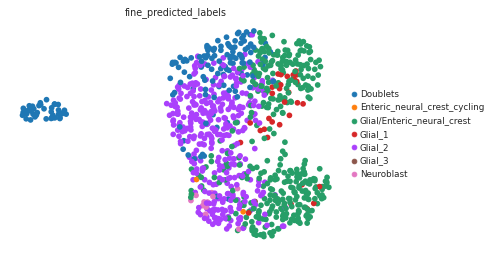

In [15]:
sc.pl.umap(adata, color=['fine_predicted_labels'])

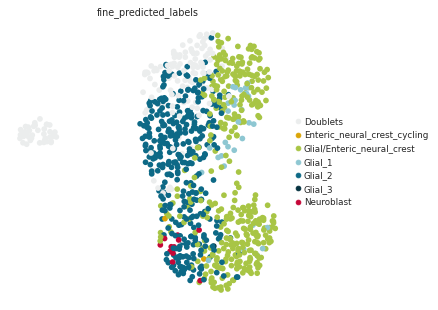

In [16]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels',palette = [
    '#ebeded',#doublets
    '#DBA507',#enteric neural crest (ENC)                                       
           '#a8c545',#glial/ENC, 
    '#8EC7D2',#glial1
           '#0D6986',#glial2
           '#053240',#glial3
    '#c50637'#neuroblast
          ]
           ,save='Neural_scanviannot_predicted.pdf')

In [17]:
adata.X.max()

2713.0

In [18]:
adata.layers['counts'] = adata.X

In [19]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


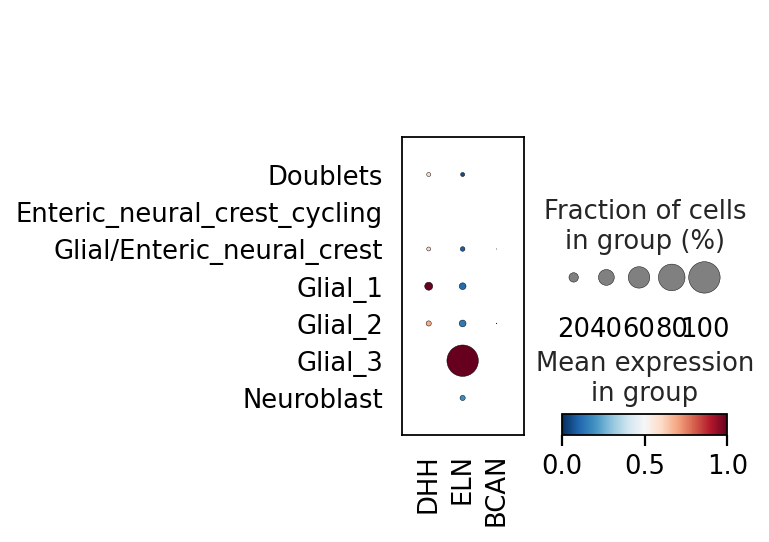

In [20]:
sc.set_figure_params(dpi_save = 300)
sc.pl.dotplot(adata,var_names=['DHH','ELN','BCAN'],groupby='fine_predicted_labels',color_map='RdBu_r', standard_scale='var')

In [21]:
uncert = adata.obs[['fine_predicted_labels','fine_predicted_labels_uncertainty']] 

In [22]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(adata.obs['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.6000240206718445


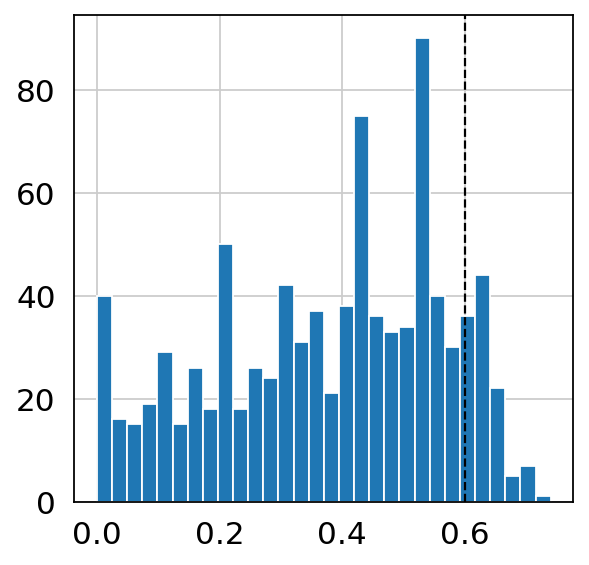

In [23]:
#plot uncertainty distribution
plt.hist(adata.obs['fine_predicted_labels_uncertainty'], bins=30)
plt.axvline(x=p, color='black', linestyle='dashed', linewidth=1)
plt.savefig('Neural_scanviannot_uncertdist.pdf', format='pdf')
plt.show()

In [24]:
uncert['fine_predicted_labels'] = uncert['fine_predicted_labels'].cat.add_categories('Unknown')

<ipython-input-24-905f2ed234d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncert['fine_predicted_labels'] = uncert['fine_predicted_labels'].cat.add_categories('Unknown')


In [25]:
adata.obs['fine_predicted_labels'].unique()

['Glial_2', 'Glial/Enteric_neural_crest', 'Doublets', 'Glial_1', 'Neuroblast', 'Glial_3', 'Enteric_neural_crest_cycling']
Categories (7, object): ['Doublets', 'Enteric_neural_crest_cycling', 'Glial/Enteric_neural_crest', 'Glial_1', 'Glial_2', 'Glial_3', 'Neuroblast']

In [26]:
#mark cells are unknown based on cut off of 90th percentile rounded to the nearest second decimal
uncert.loc[uncert["fine_predicted_labels_uncertainty"] > 0.60, "fine_predicted_labels"] = "Unknown"

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [27]:
adata.obs['fine_predicted_labels_uncertflagged'] = adata.obs['fine_predicted_labels']

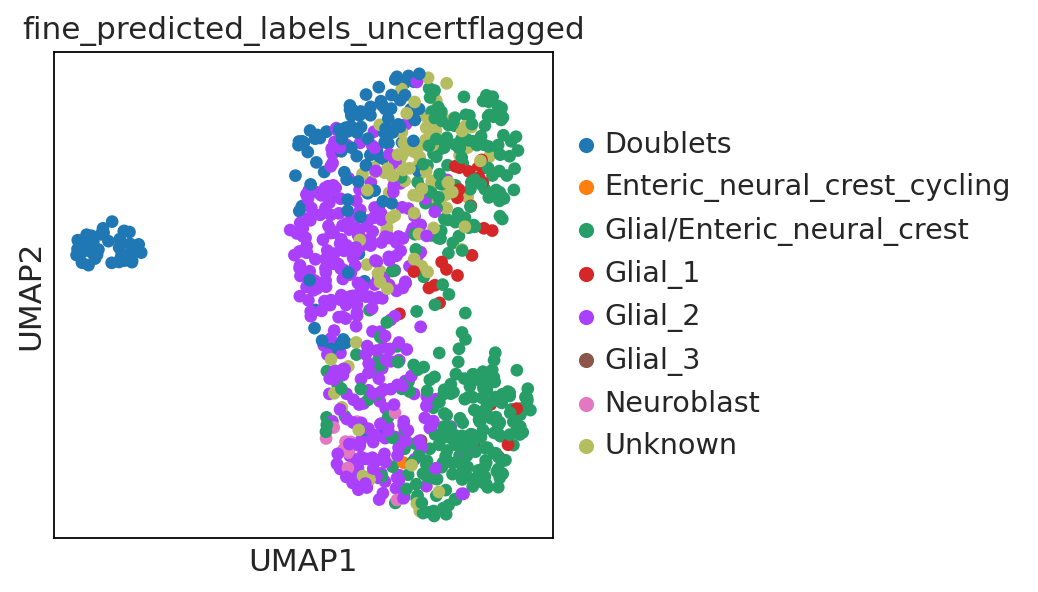

In [28]:
ON = {O:N for O,N in zip(uncert.index,uncert["fine_predicted_labels"])}
adata.obs["fine_predicted_labels_uncertflagged"] = [ON[O] if O in ON else N for O,N in zip(adata.obs_names, adata.obs["fine_predicted_labels_uncertflagged"])]
sc.pl.umap(adata,color='fine_predicted_labels_uncertflagged')

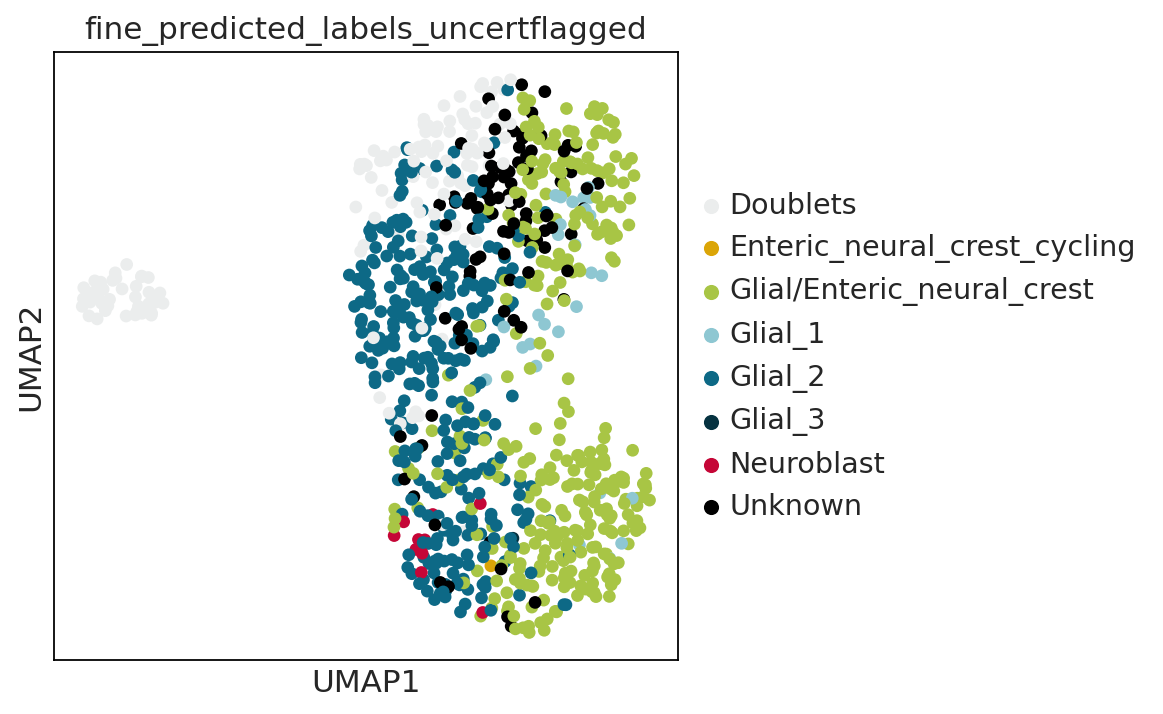

In [29]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels_uncertflagged',palette = ['#ebeded',#doublets
    '#DBA507',#enteric neural crest (ENC)                                       
           '#a8c545',#glial/ENC, 
    '#8EC7D2',#glial1
           '#0D6986',#glial2
           '#053240',#glial3
            '#c50637',#neuroblast
            '#000000'

                                                                       ],save='Neural_scanviannot_uncert.pdf')

In [30]:
annot = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/disease_annot/resolved_annot/Neural_disease_annot.csv',index_col=0)

In [31]:
adata.obs['fine_predicted_labels_resolved'] = annot.fine_predicted_labels_resolved

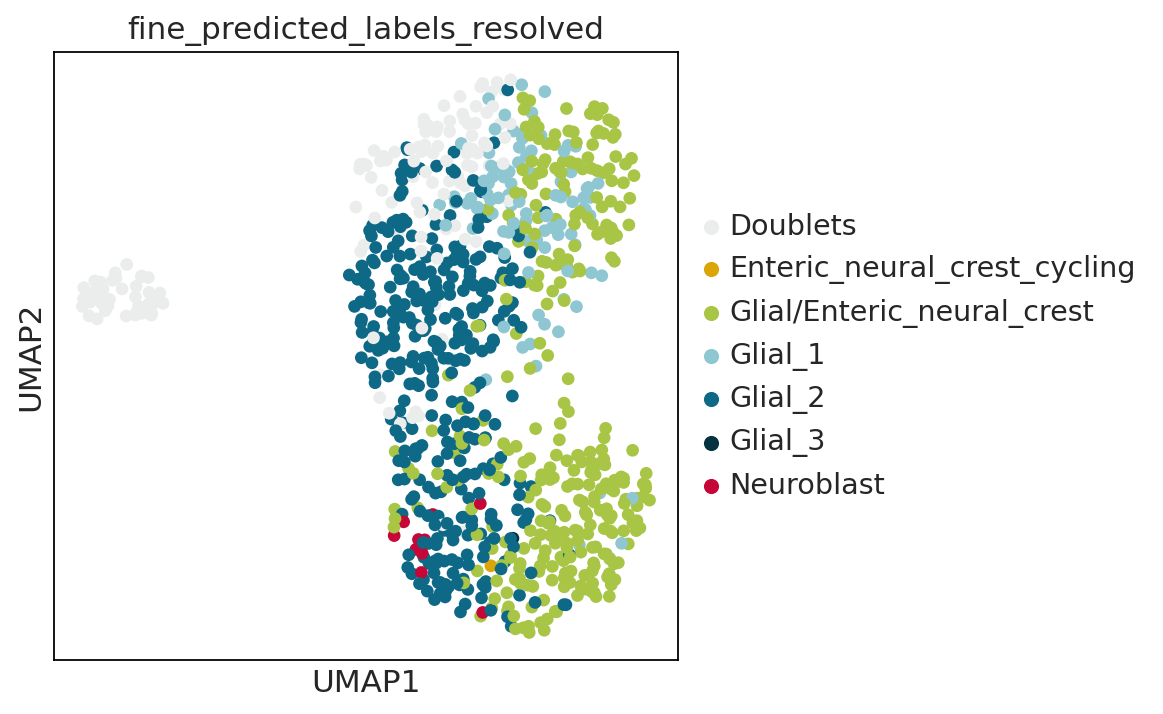

In [32]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels_resolved',palette = ['#ebeded',#doublets
    '#DBA507',#enteric neural crest (ENC)                                       
           '#a8c545',#glial/ENC, 
    '#8EC7D2',#glial1
           '#0D6986',#glial2
           '#053240',#glial3
            '#c50637'#neuroblast
    
                                              ],save='Neural_scanviannot_resolved.pdf')

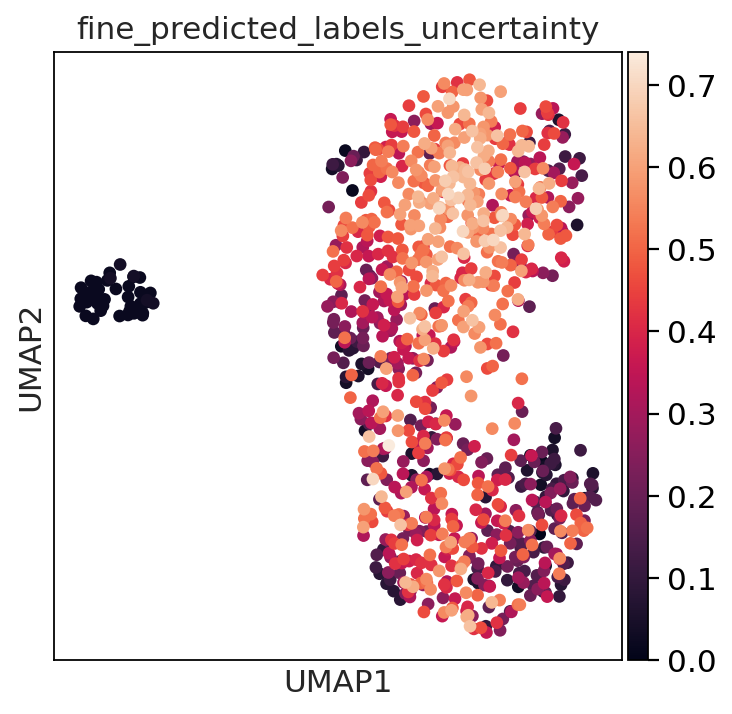

In [33]:
sc.pl.umap(adata,color='fine_predicted_labels_uncertainty',save='Neural_scanviannot_uncertainty.pdf')

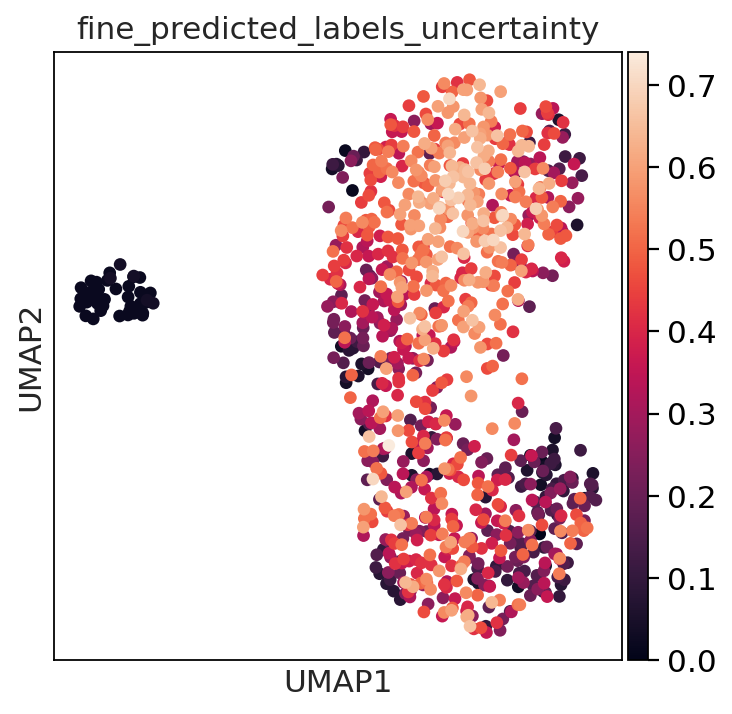

In [34]:
sc.pl.umap(adata,color='fine_predicted_labels_uncertainty')

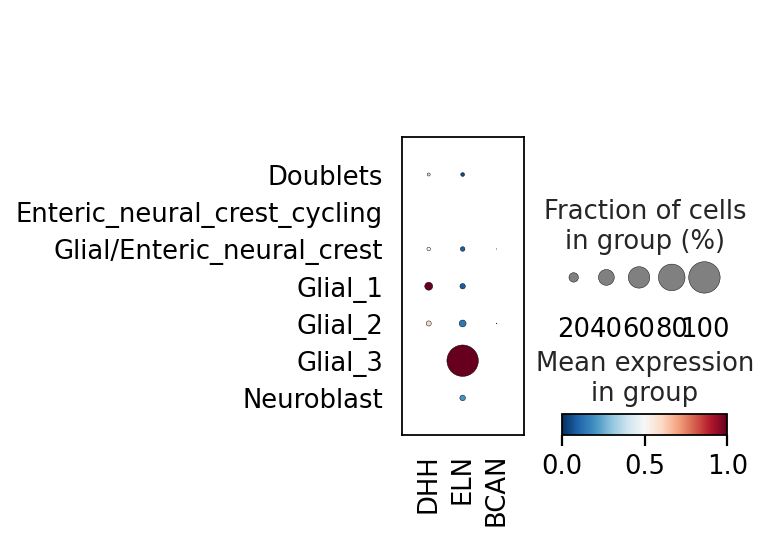

In [35]:
sc.set_figure_params(dpi_save = 300)
sc.pl.dotplot(adata,var_names=['DHH','ELN','BCAN'],groupby='fine_predicted_labels_resolved',color_map='RdBu_r', standard_scale='var',save='Neural_resolvedmarkers.pdf')

In [36]:
colors={
    'Doublets':'#ebeded',
    'EC_venous': '#2a4858',
  'Mast': '#826e91',
  'EC_capillary': '#855f9a',
  'DC_cDC1': '#8c543f',
  'Monocyte': '#5baf07',
  'DC_cDC2': '#cfdb65',
  'Basal': '#727271',
  'Treg_IL10': '#e5c510',
  'Crypt_fibroblast_PI16': '#bd7879',
  'Macrophage': '#486626',
  'Vascular_smooth_muscle': '#1E4147',
  'Lamina_propria_fibroblast_ADAMDEC1': '#e95e50',
  'Epithelial_cycling_G2M': '#ff3c4b',
  'Keratinocyte_stratified': '#EDD3E0',
  'Trm/em_CD8': '#256b87',
  'Pericyte': '#437356',
  'Oral_mucosa_fibroblast': '#303267',
  'Macrophage_MMP9': '#a5f002',
  'EC_lymphatic': '#999999',
  'Rectum_fibroblast': '#522e25',
  'Trm_Th17': '#1e093f',
  'DC_migratory': '#e6a519',
  'Epithelial_cycling_S': '#ff8433',
  'Trm_CD4': '#8107ed',
  'NK_CD16': '#0c1e0e',
  'Macrophage_LYVE1': '#8fd9d0',
  'Trm_CD8': '#2844c1',
  'Macrophage_TREM2': '#42c7ac',
  'Keratinocyte_inflammatory': '#E0AC9D',
  'Tnaive/cm_CD4': '#9c53bc',
  'DC_pDC': '#bdb197',
  'Villus_fibroblast_F3': '#d64582',
  'EC_arterial_2': '#ca6092',
  'EC_arterial_1': '#fa6e6e',
  'gdT': '#3fafb5',
  'B_memory': '#a33c22',
  'T/NK_cycling': '#c260ff',
  'Immune_recruiting_pericyte': '#AAC789',
  'MAIT': '#21b796',
  'ILC3': '#778c00',
  'Melanocyte': '#886F61',
  'Tfh_naive': '#5e3c55',
  'Keratinocyte_outer': '#BF7A9C',
  'EC_cycling': '#fac06e',
  'Tnaive/cm_CD8': '#5ca4ce',
  'NK_CD56bright': '#3f8c08',
  'B_naive': '#9b0319',
  'B_preB': '#8a4682',
  'Treg': '#f98261',
  'B_proB': '#d34794',
  'B_plasmablast': '#9e53db',
  'B_plasma_IgG': '#632f17',
  'Megakaryocyte/platelet': '#c730aa',
  'TA': '#b85f1c',
  'Mono/neutrophil_MPO': '#2a497a',
  'B_plasma_IgA1': '#f76c56',
  'Macrophage_CD5L': '#caf9cf',
  'Tfh': '#5e0b30',
  'Oesophagus_fibroblast': '#63A0C0',
  'B_plasma_IgA2': '#d6558d',
  'gdT_naive': '#26daf2',
  'B_GC_I': '#db9602',
  'B_plasma_IgM': '#c66d31',
  'DC_langerhans': '#c7a642',
  'Fibroblast_reticular': '#f0c134',
  'B_GC_II': '#e2d138',
  'Follicular_DC': '#f0982c',
  'Microfold': '#e55b85',
  'Enterocyte': '#e1b5e6',
  'Epithelial_stem': '#c924b9',
  'Surface_foveolar': '#d9b74a',
  'Mucous_gland_neck': '#f7b37c',
  'Cycling': '#ff8433',
  'Pareital': '#d45f80',
  'Enteroendocrine_MX': '#292663',
  'Myofibroblast': '#CCAE91',
  'Glial_2': '#0D6986',
  'Enteric_neural_crest_cycling': '#DBA507',
  'Enterochromaffin': '#22517a',
  'Chief': '#c95340',
  'Glial/Enteric_neural_crest': '#a8c545',
  'Enteroendocrine_G': '#2f3f4d',
  'Neuroblast': '#c50637',
  'Goblet_progenitor': '#e9f7ad',
  'Goblet': '#6c9939',
  'Enteroendocrine': '#68b7fc',
  'Erythrocytes': '#0e539c',
  'Enteroendocrine_X': '#7292ad',
  'Glial_3': '#053240',
  'Goblet_cycling': '#d1d14f',
  'BEST4_enterocyte_colonocyte': '#39997c',
  'Tuft': '#9d9dff',
  'Paneth': '#79508f',
  'Serous': '#C9DE55',
  'Mucous': '#67cc8e',
  'Duct': '#7D9100',
  'Seromucous': '#ACEBAE',
  'Myoepithelial': '#572300',
  'Ionocytes': '#9d9dff',
  'Colonocyte': '#d66245',
  'Mature_colonocyte': '#fa6161',
  'Mesoderm_2': '#b4793b',
  'Branch_A_inhibtory_motor_neuron': '#a39bcb',
  'SMC_PPLP2': '#d4d4e8',
  'Cycling_fibroblast': '#d65151',
  'ICC': '#69479b',
  'Branch_B_excitatory_motor_neuron': '#496695',
  'SMC_CAPN3': '#968dc6',
  'Mesoderm_1': '#663818',
  'Branch_B_primary_afferent_neuron': '#909134',
  'Proximal_progenitor_DUO/JEJ': '#fac219',
  'SMC_CAPN3_cycling': '#76738e',
  'Glial_1': '#8EC7D2',
  'Branch_A_primary_afferent_neuron': '#27bdbf',
  'Branch_A_interneuron': '#67608a',
  'NTS': '#baada4',
  'Proximal_progenitor_ILE': '#8f6e0d',
  'Enteroendocrine_progenitor': '#aeebdf',
  'Mesothelium': '#8F6592',
  'Distal_progenitor': '#dbc697',
  'Angiogenic_pericyte': '#308587',
  'Eosinophil/basophil': '#8b4eba',
  'CLDN10': '#706d65',
  'Distal_progenitor_PRAC1': '#8f8161',
  'Immature_pericyte': '#90c496',
  'Mesenchymal_LTO': '#f7eb59',
  'Gastric_fetal_epithelial': '#a01160',
  'DCS_MUC17_cycling': '#99216b',
  'DCS_MUC17': '#9c6b73',
  'Gland_basal': '#404040',
  'Gland_fetal': '#168039',
  'Basal_cycling': '#d1bf82',
  'Keratinocyte_fetal': '#d8306e',
  'Gland_duct': '#7D9100',
  'Gland_mucous': '#67cc8e',
  'Myoblast/myocyte': '#e2798d',
  'Unknown': '#000000'}

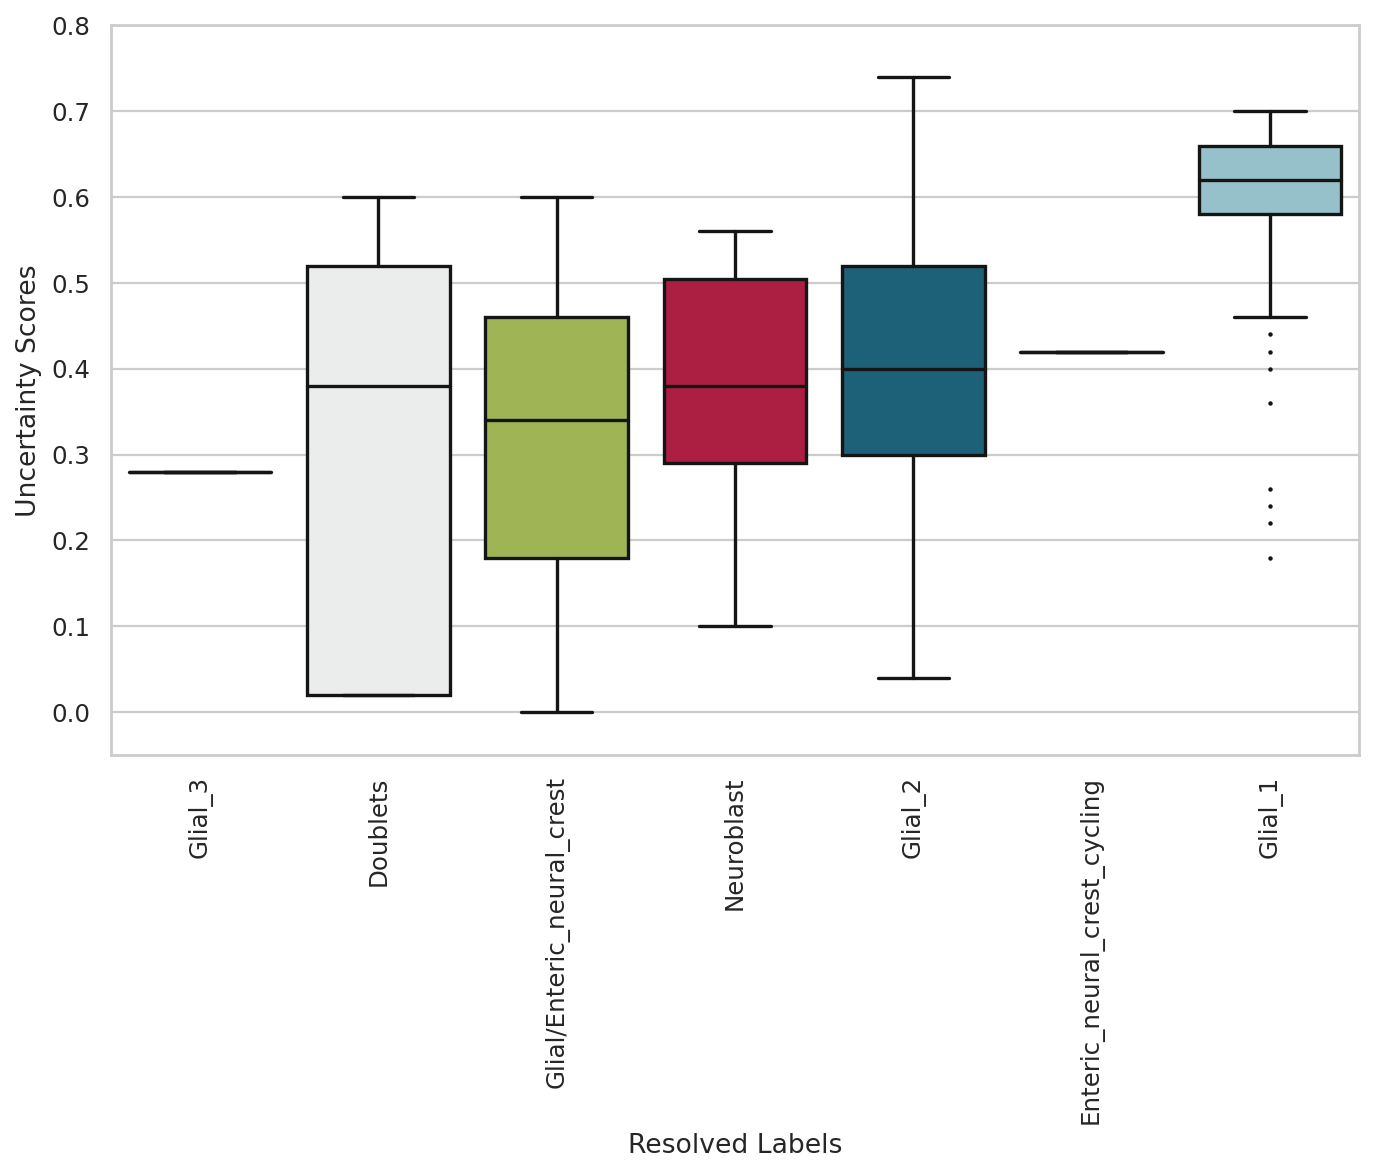

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, but seaborn can enhance the style

# Assuming adata is your AnnData object

# Combine the two variables into a DataFrame for easier plotting
data_to_plot = adata.obs[['fine_predicted_labels_uncertainty', 'fine_predicted_labels_resolved']]

# Use seaborn for better styling (optional)
sns.set(style="whitegrid")

mean_uncertainty = data_to_plot.groupby('fine_predicted_labels_resolved')['fine_predicted_labels_uncertainty'].mean()

# Sort the categories based on mean uncertainty
sorted_categories = mean_uncertainty.sort_values().index

# Create a box and whisker plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
ax = sns.boxplot(x='fine_predicted_labels_resolved', y='fine_predicted_labels_uncertainty', 
            data=data_to_plot,palette=colors,order=sorted_categories,flierprops=dict(marker='o', markerfacecolor='gray', markersize=1))

# Add labels and title
plt.xticks(rotation=90)
plt.xlabel('Resolved Labels')
plt.ylabel('Uncertainty Scores')
ax.set_ylim(-0.05, 0.8)

# Save the plot as a PDF file
plt.savefig('Neural_boxplot_uncertainty_scores.pdf', format='pdf')

# Show the plot
plt.show()

In [38]:
#related to revisions point 2.10 "Have you done differential gene expression analysis of the unknonw cells versus the annotated cells in their cluster?"

In [39]:
adata

AnnData object with n_obs × n_vars = 918 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_splic

In [40]:
adata.obs['unknown_clusterlabel'] = adata.obs['fine_predicted_labels_uncertflagged'].astype(str) + '_' + adata.obs['fine_predicted_labels_resolved'].astype(str)

In [41]:
adata.obs['unknown_clusterlabel'].value_counts()

Glial/Enteric_neural_crest_Glial/Enteric_neural_crest        328
Glial_2_Glial_2                                              321
Doublets_Doublets                                            135
Unknown_Glial_1                                               67
Unknown_Glial_2                                               28
Glial_1_Glial_1                                               27
Neuroblast_Neuroblast                                         10
Glial_3_Glial_3                                                1
Enteric_neural_crest_cycling_Enteric_neural_crest_cycling      1
Name: unknown_clusterlabel, dtype: int64

In [42]:
adata.X.max()

7.8417106

In [44]:
adata_compare = adata[~adata.obs.unknown_clusterlabel.isin(['Glial_3_Glial_3','Enteric_neural_crest_cycling_Enteric_neural_crest_cycling'])].copy()

         Falling back to preprocessing with `sc.pp.pca` and default params.


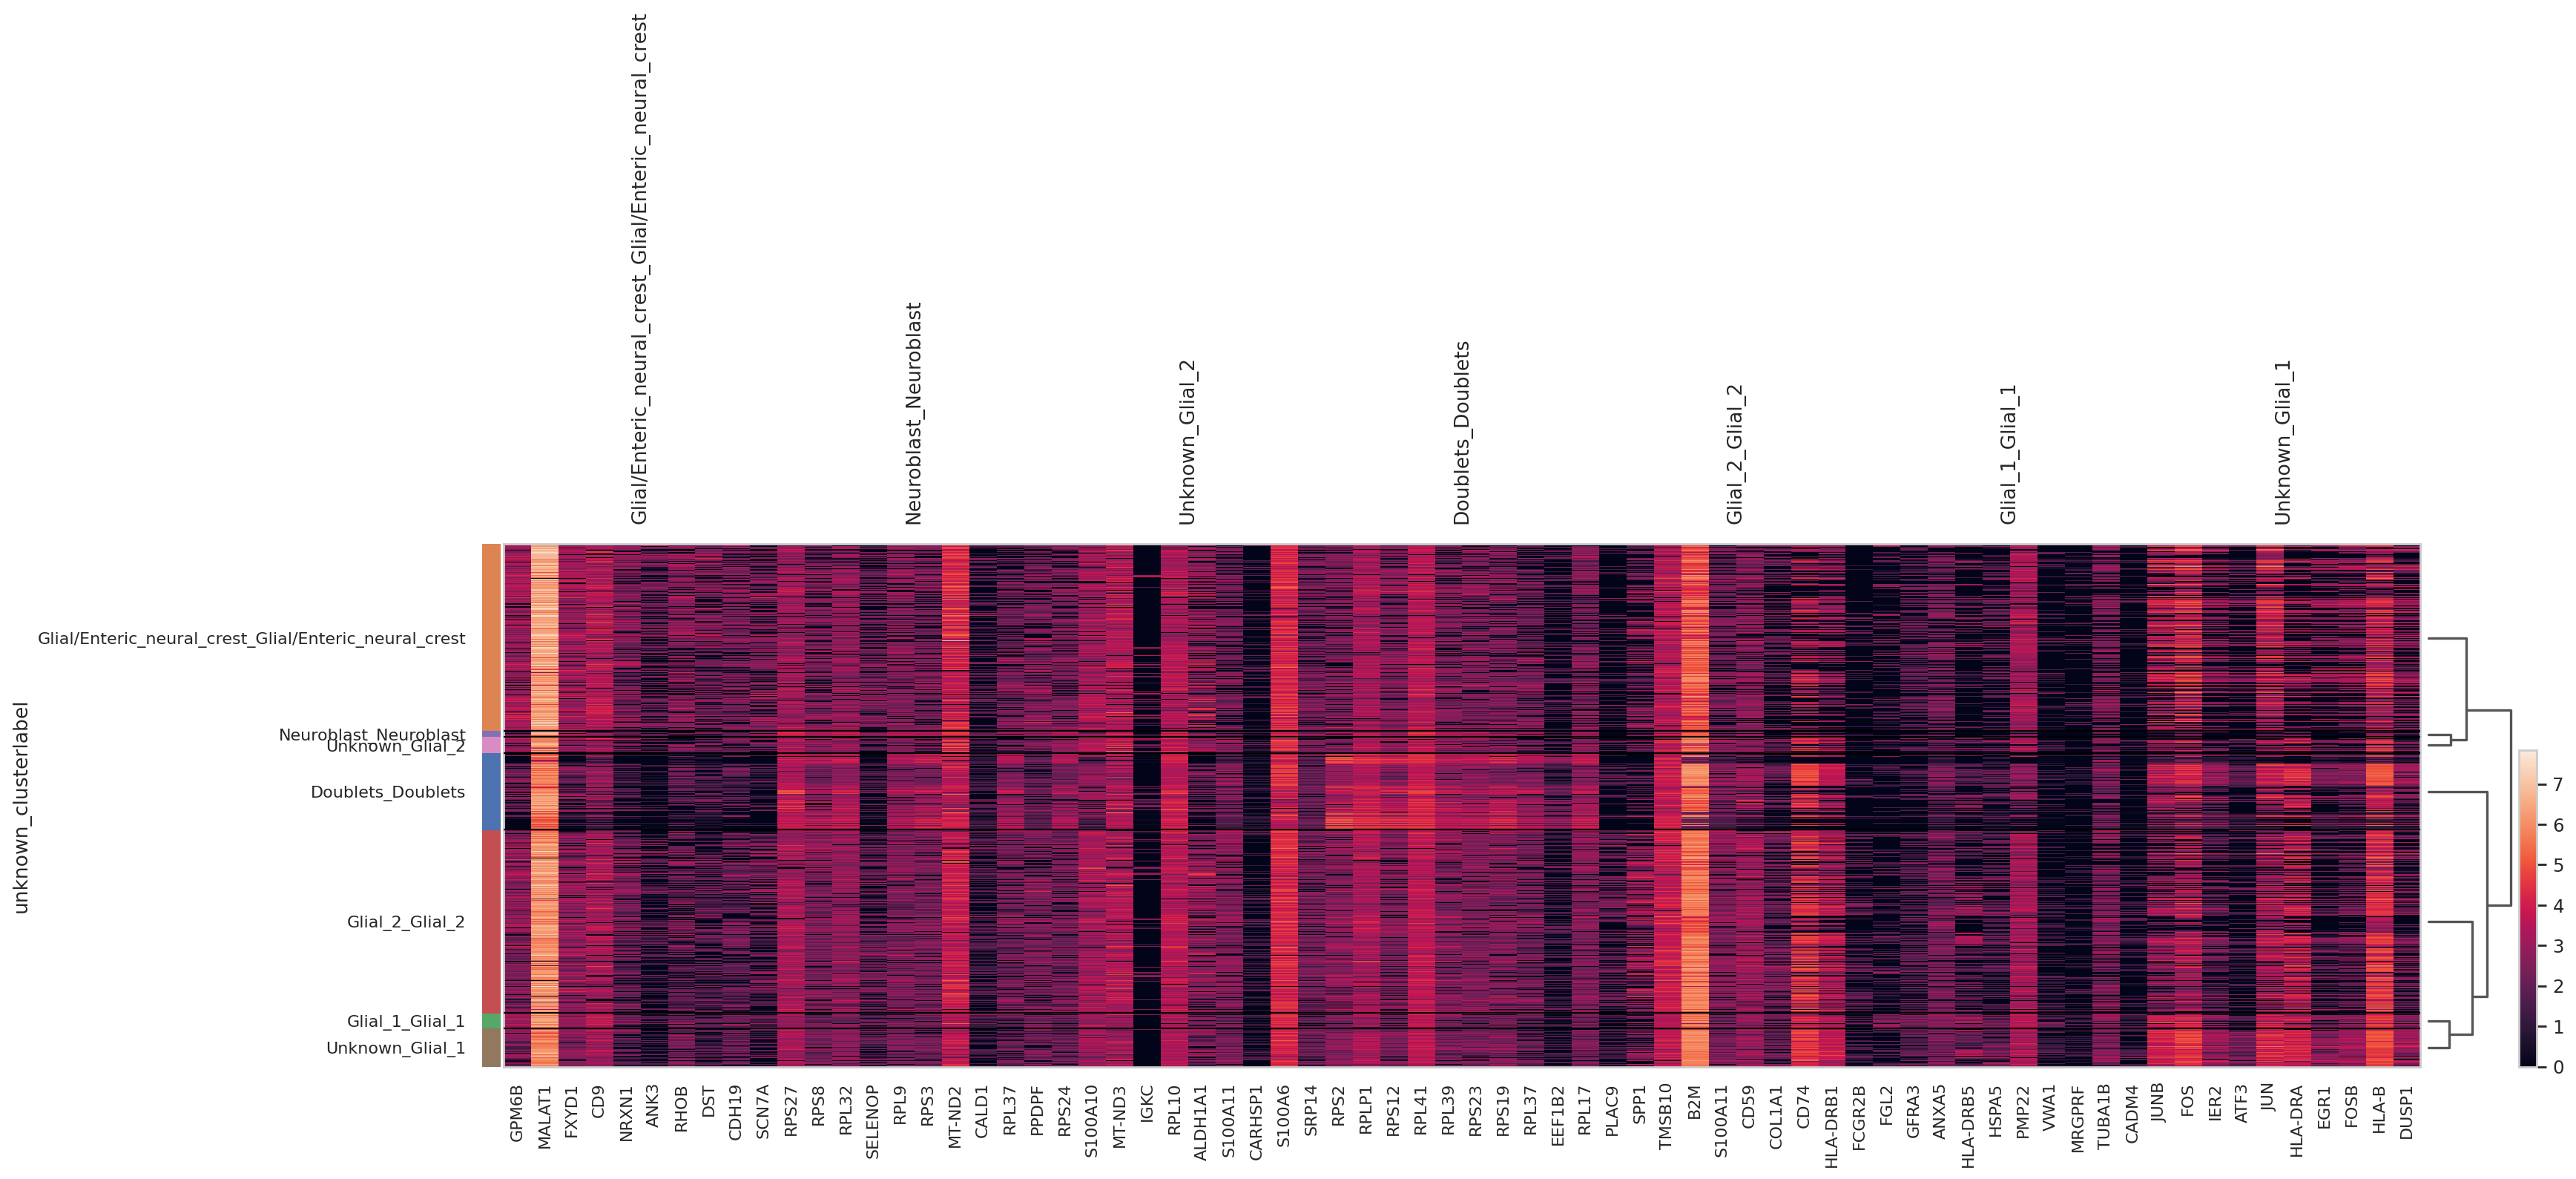

In [47]:
sc.tl.rank_genes_groups(adata_compare, 'unknown_clusterlabel', method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata_compare, show_gene_labels=True)

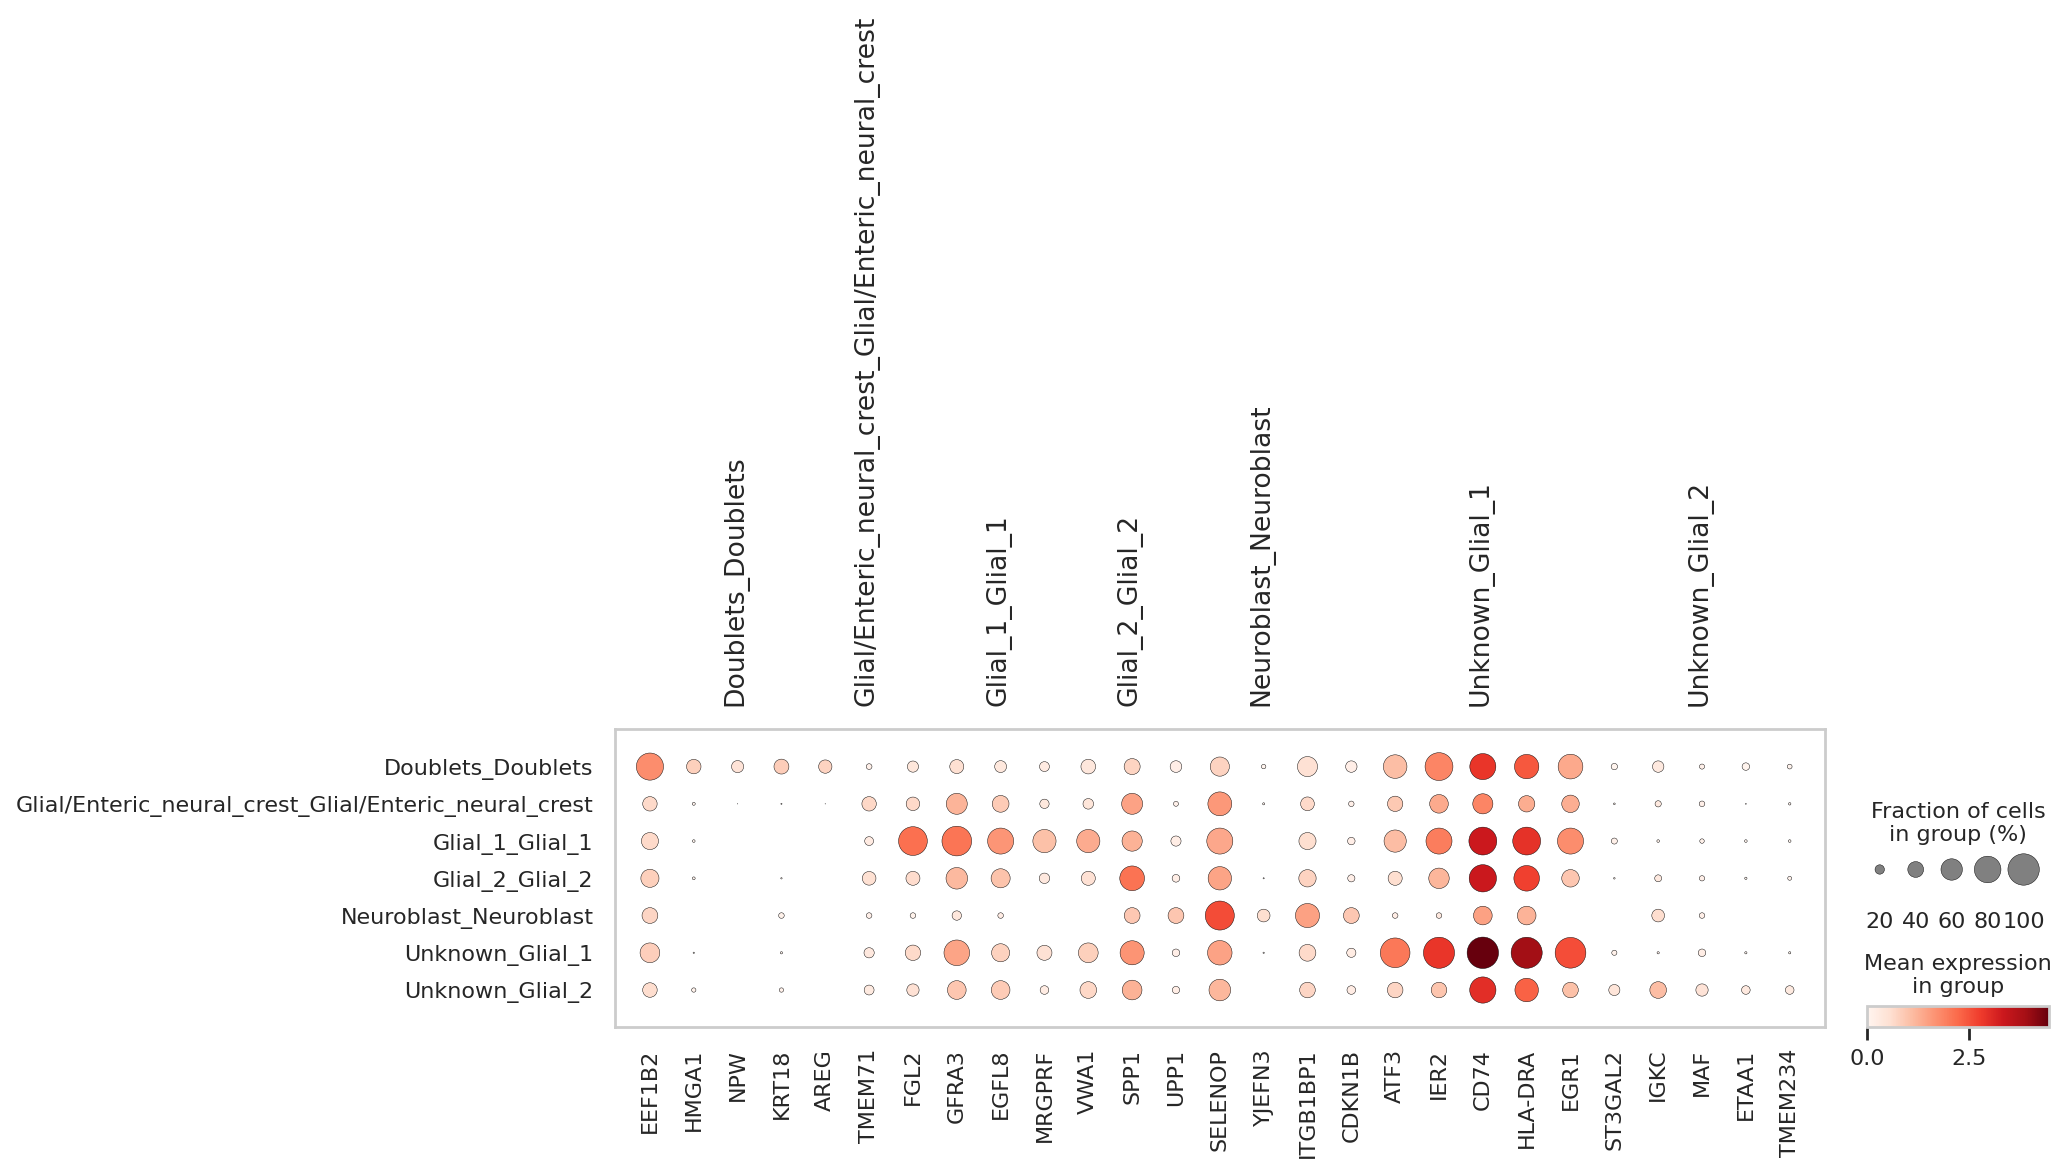

In [48]:
import sys
sys.path.append("/home/jovyan/ao15/Megagut/")
from re5_combine import *
adata_compare.raw = adata_compare.copy()
mkst = calc_marker_stats(adata_compare, groupby="unknown_clusterlabel")
mks = filter_marker_stats(mkst[2], min_frac_diff=0.1, min_mean_diff=0.1, max_next_frac=0.5, max_next_mean=0.95, strict=False, how='or')
plot_markers(adata_compare, groupby='unknown_clusterlabel', mks=mks)

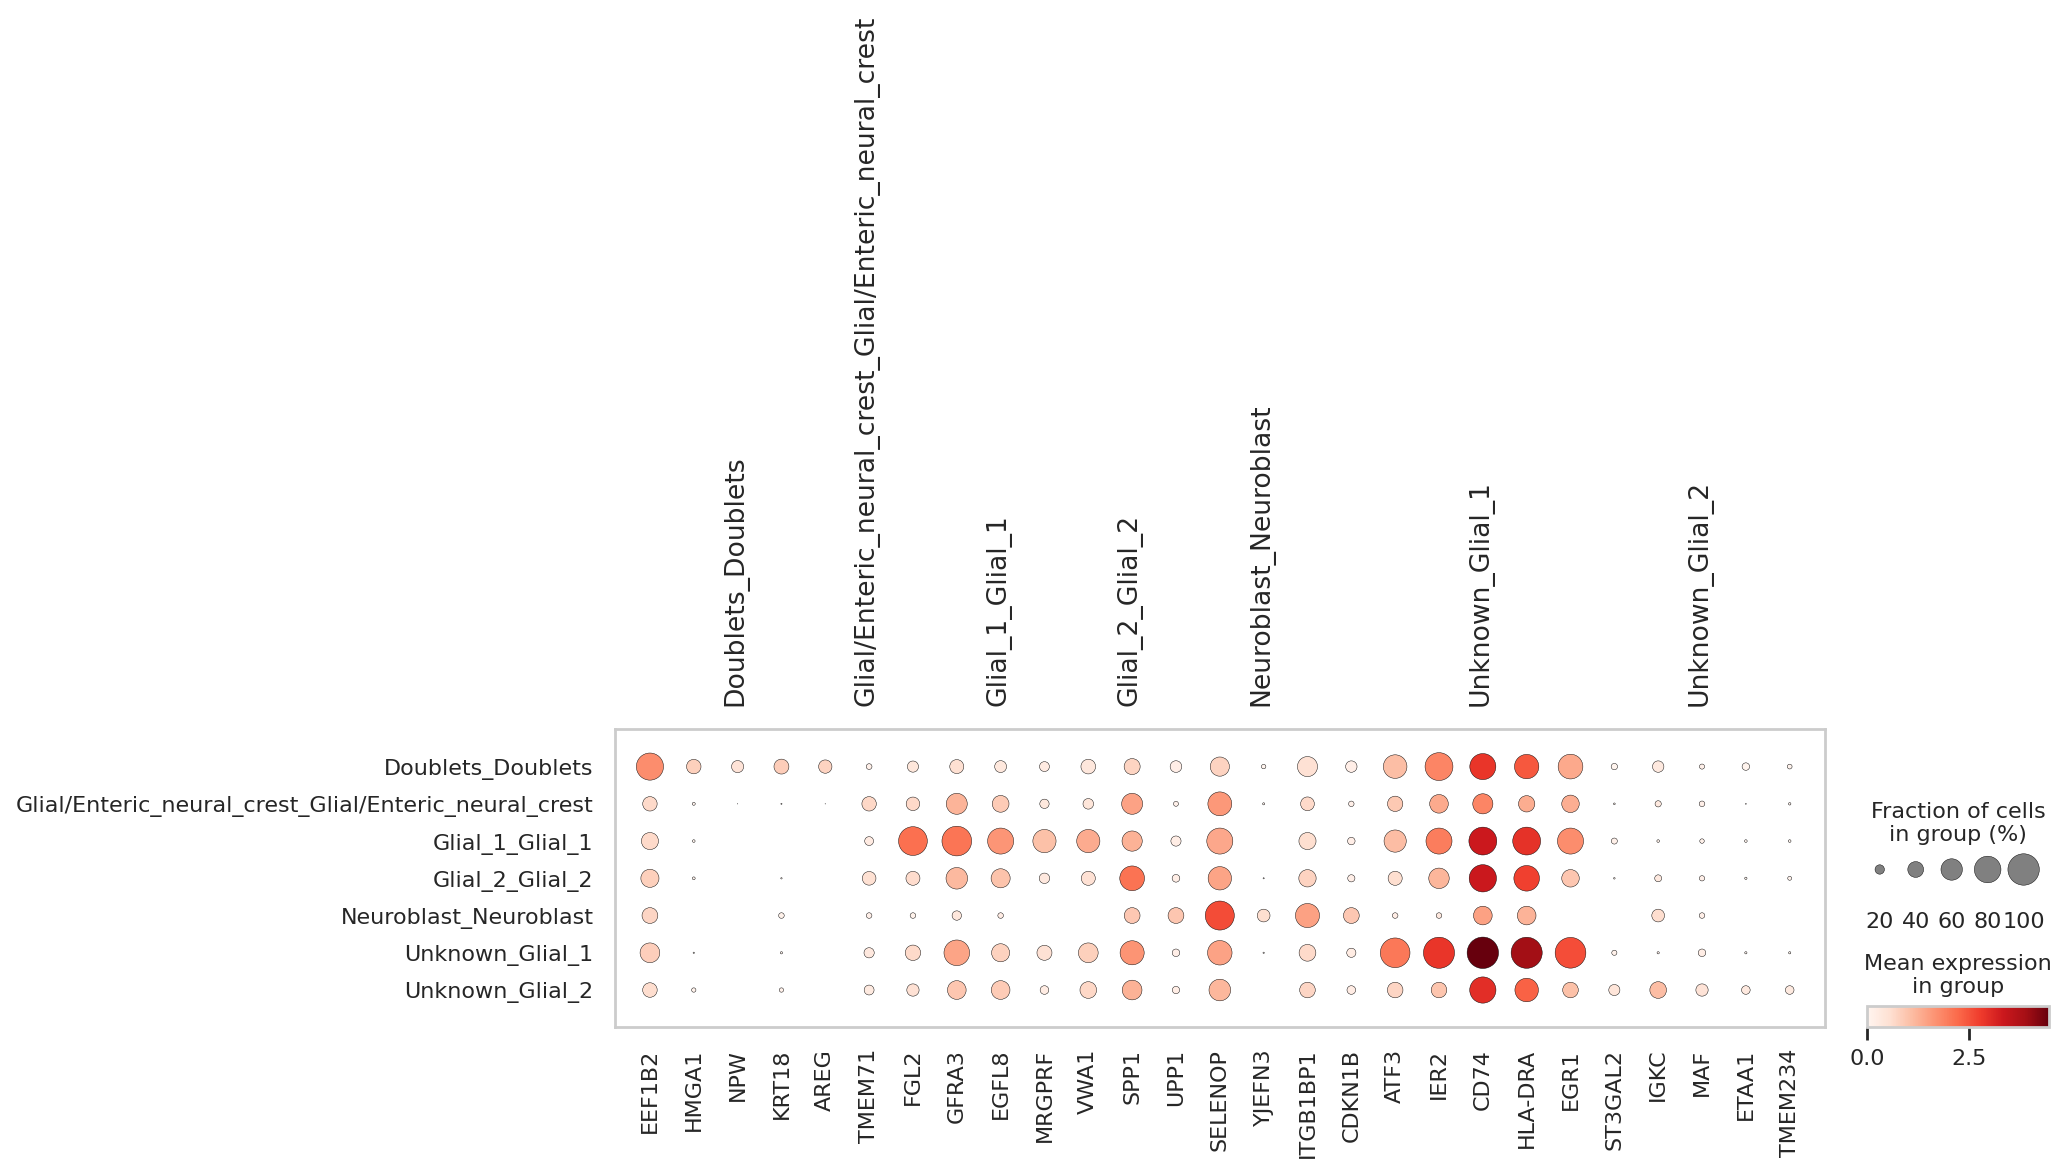

In [49]:
plot_markers(adata_compare, groupby='unknown_clusterlabel', mks=mks,save='Neural_unknown_specificDGE.pdf')